##### PCA

In [ ]:
import os, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

warnings.filterwarnings("ignore")
rng = 42
np.random.seed(rng)

CSV_PATH = "/kaggle/working/features_256d_efficientnet.csv"  
OUT_DIR  = "/kaggle/working/PCA_XX"                       
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
feat_cols = [c for c in df.columns if c.startswith("f") and c[1:].isdigit()]
if not feat_cols:
    raise RuntimeError("Expected feature columns like f000,f001,...")

X = df[feat_cols].values.astype(np.float32)
y = df["class_idx"].values.astype(int)
labels = df["label"] if "label" in df.columns else pd.Series(y, name="label")
classes = np.unique(y)
n_classes = len(classes)

X_tmp, X_test, y_tmp, y_test, idx_tmp, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.20, stratify=y, random_state=rng
)

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_tmp, y_tmp, idx_tmp, test_size=0.125, stratify=y_tmp, random_state=rng
)
print({"train": len(y_train), "val": len(y_val), "test": len(y_test)})


scaler = StandardScaler().fit(X_train)
Z_tr, Z_va, Z_te = scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test)
Z_all = scaler.transform(X)

candidates = [0.90, 0.93, 0.95, 0.97, 0.98, 0.99]
best = {"keep": None, "ll": 1e9, "pca": None, "retained": None, "n_comp": None}

for keep in candidates:
    pca = PCA(n_components=keep, random_state=rng)
    Ztr_p = pca.fit_transform(Z_tr)
    Zva_p = pca.transform(Z_va)

    lr = LogisticRegression(
        max_iter=4000, multi_class="multinomial", solver="lbfgs", n_jobs=-1, C=1.0
    )
    lr.fit(Ztr_p, y_train)
    P_val = lr.predict_proba(Zva_p)
    ll = log_loss(y_val, P_val, labels=classes)

    if ll < best["ll"]:
        best["keep"] = keep
        best["ll"] = ll
        best["pca"] = pca
        best["retained"] = float(np.sum(pca.explained_variance_ratio_))
        best["n_comp"] = int(Ztr_p.shape[1])

choose_keep = best["keep"]
pca = best["pca"]
retained = best["retained"]
n_keep = best["n_comp"]
print(f"Chosen keep={choose_keep:.2f} → n_components={n_keep}, retained={retained*100:.2f}% (by VAL log-loss)")


Ztr_p = pca.transform(Z_tr)
Zva_p = pca.transform(Z_va)
Zte_p = pca.transform(Z_te)
Zall_p = pca.transform(Z_all)


OUT_DIR_FINAL = f"/kaggle/working/PCA_{n_keep}"
if OUT_DIR_FINAL != OUT_DIR:
    try:
        os.rename(OUT_DIR, OUT_DIR_FINAL)
    except FileExistsError:
        pass
OUT_DIR = OUT_DIR_FINAL
os.makedirs(OUT_DIR, exist_ok=True)

pc_cols = [f"pc{i+1:03d}" for i in range(n_keep)]

def save_split(path_csv, Zp, idxs):
    d = pd.DataFrame(Zp, columns=pc_cols)
    d["class_idx"] = y[idxs]
    d["label"] = labels.iloc[idxs].values
    d.to_csv(path_csv, index=False)


df_all = pd.DataFrame(Zall_p, columns=pc_cols)
df_all["class_idx"] = y
df_all["label"] = labels.values
combined_csv = os.path.join(OUT_DIR, f"features_pca_{n_keep}comps.csv")
df_all.to_csv(combined_csv, index=False)

save_split(os.path.join(OUT_DIR, f"train_pca_{n_keep}comps.csv"), Ztr_p, idx_train)
save_split(os.path.join(OUT_DIR, f"val_pca_{n_keep}comps.csv"),   Zva_p, idx_val)
save_split(os.path.join(OUT_DIR, f"test_pca_{n_keep}comps.csv"),  Zte_p, idx_test)


meta = {
    "random_state": rng,
    "original_dim": int(X.shape[1]),
    "chosen_keep": float(choose_keep),
    "n_components": int(n_keep),
    "retained_variance_train": float(retained), 
    "val_logloss_for_choice": float(best["ll"]),
    "paths": {
        "combined_csv": combined_csv,
        "train_csv": os.path.join(OUT_DIR, f"train_pca_{n_keep}comps.csv"),
        "val_csv":   os.path.join(OUT_DIR, f"val_pca_{n_keep}comps.csv"),
        "test_csv":  os.path.join(OUT_DIR, f"test_pca_{n_keep}comps.csv"),
    },
    "class_count": int(n_classes),
    "classes_preview": [int(c) for c in classes[:10]],
    "feature_columns_preview": feat_cols[:10] + (["..."] if len(feat_cols) > 10 else [])
}
with open(os.path.join(OUT_DIR, "pca_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

plt.figure(figsize=(7,5))
plt.plot(np.arange(1, len(expl_var)+1), expl_var, marker="o")
plt.title("Scree Plot (Explained Variance per PC) — Train-only PCA")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.axvline(n_keep, color="red", linestyle="--")
plt.savefig(os.path.join(OUT_DIR, "scree_plot.png"), dpi=160, bbox_inches="tight")
plt.close()

plt.figure(figsize=(7,5))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker="o")
plt.title(f"Cumulative Variance — chosen {n_keep} PCs")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(choose_keep, color="green", linestyle="--")
plt.axvline(n_keep, color="red", linestyle="--")
plt.savefig(os.path.join(OUT_DIR, "cumulative_variance.png"), dpi=160, bbox_inches="tight")
plt.close()

plt.figure(figsize=(7,6))
plt.scatter(Zall_p[:,0], Zall_p[:,1], c=y, cmap="tab10", s=10, alpha=0.7)
plt.title("PCA projection (PC1 vs PC2) — transform by TRAIN-fitted PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="class")
plt.savefig(os.path.join(OUT_DIR, "after_pca_2d.png"), dpi=160, bbox_inches="tight")
plt.close()

if n_keep >= 3:
    from mpl_toolkits.mplot3d import Axes3D  
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(Zall_p[:,0], Zall_p[:,1], Zall_p[:,2], c=y, cmap="tab10", s=10, alpha=0.7)
    ax.set_title("PCA projection (PC1–PC3) — transform by TRAIN-fitted PCA")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    fig.colorbar(sc, pad=0.1, label="class")
    plt.savefig(os.path.join(OUT_DIR, "after_pca_3d.png"), dpi=160, bbox_inches="tight")
    plt.close()

print("\n=== PCA (train-only) Summary ===")
print(f"Original dim: {X.shape[1]}")
print(f"Chosen keep:  {choose_keep:.2f}")
print(f"Selected n_components: {n_keep}")
print(f"Retained variance (train): {retained*100:.2f}%")
print("Saved to:", OUT_DIR)


##### Smote + PCA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Load balanced features
df = pd.read_csv('/kaggle/working/resnet50_features_SMOTE_Tomek.csv')
print("Shape:", df.shape)
print("Columns:", df.columns[:10], "...")

# Drop label column for PCA
feature_cols = [c for c in df.columns if c != 'label']
X = df[feature_cols].values
y = df['label'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components (SMOTE+Tomek)')
plt.grid()
plt.tight_layout()
plt.savefig('/kaggle/working/pca_explained_variance_SMOTE_Tomek.png')
plt.show()

# Number of components for 90% and 95% variance
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_90 = np.argmax(cum_var >= 0.90) + 1
n_95 = np.argmax(cum_var >= 0.95) + 1
print(f'Number of PCs for 90% variance: {n_90}')
print(f'Number of PCs for 95% variance: {n_95}')

# Save reduced PCA features (95%)
X_pca_final = X_pca[:, :n_95]
df_pca = pd.DataFrame(X_pca_final, columns=[f'pca_{i+1}' for i in range(n_95)])
df_pca['label'] = y
out_csv = '/kaggle/working/resnet50_features_SMOTE_Tomek_PCA.csv'
df_pca.to_csv(out_csv, index=False)
print(f"PCA (SMOTE+Tomek) features saved to: {out_csv}")

# 2D PCA Plot (first 2 components)
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, s=15, alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA Projection (SMOTE+Tomek)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/pca_2d_plot_SMOTE_Tomek.png')
plt.show()

# 3D PCA Plot (first 3 components)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(y):
    idx = y == label
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], label=label, s=15, alpha=0.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('3D PCA Projection (SMOTE+Tomek)')
ax.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/pca_3d_plot_SMOTE_Tomek.png')
plt.show()


#### Smote

In [ ]:
!pip install numpy==1.26.4 scikit-learn==1.3.2 imbalanced-learn==0.11.0 --force-reinstall --no-cache-dir
import os
os.kill(os.getpid(), 9)  # Restart kernel to apply cleanly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 241.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 290.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 269.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 316.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 338.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 288.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.

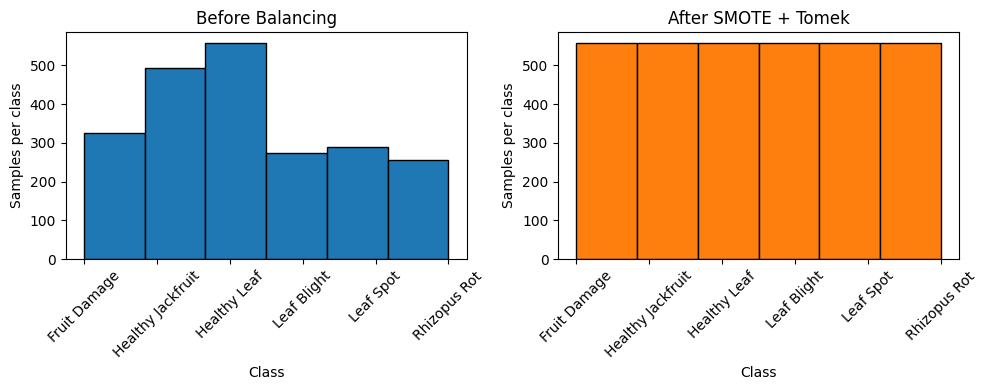

SMOTE+Tomek class distribution: Counter({'Fruit Damage': 557, 'Healthy Jackfruit': 557, 'Healthy Leaf': 557, 'Leaf Blight': 557, 'Leaf Spot': 557, 'Rhizopus Rot': 557})
Saved SMOTE+Tomek balanced features to /kaggle/working/cnn_features_SMOTE_Tomek.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.combine import SMOTETomek

# Load Data
df = pd.read_csv('/kaggle/working/custom_cnn_features.csv')
X = df.drop(['label', 'filename'], axis=1).values
y = df['label'].values

# Plot class histogram before balancing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y, bins=len(np.unique(y)), edgecolor='k')
plt.xticks(rotation=45)
plt.title('Before Balancing')
plt.xlabel('Class')
plt.ylabel('Samples per class')

# --- SMOTE + Tomek Links ---
smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X, y)

# Plot after balancing
plt.subplot(1, 2, 2)
plt.hist(y_smt, bins=len(np.unique(y_smt)), edgecolor='k', color='tab:orange')
plt.xticks(rotation=45)
plt.title('After SMOTE + Tomek')
plt.xlabel('Class')
plt.ylabel('Samples per class')
plt.tight_layout()
plt.savefig('/kaggle/working/cnn_class_balance_smote_tomek.png')
plt.show()

print("SMOTE+Tomek class distribution:", Counter(y_smt))

# --- Save SMOTE+Tomek result ---
df_smt = pd.DataFrame(X_smt)
df_smt['label'] = y_smt
df_smt.to_csv('/kaggle/working/cnn_features_SMOTE_Tomek.csv', index=False)
print("Saved SMOTE+Tomek balanced features to /kaggle/working/cnn_features_SMOTE_Tomek.csv")


    Balance + PCA

Shape: (2195, 259)
Columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object') ...
Numeric feature shape: (2195, 256)


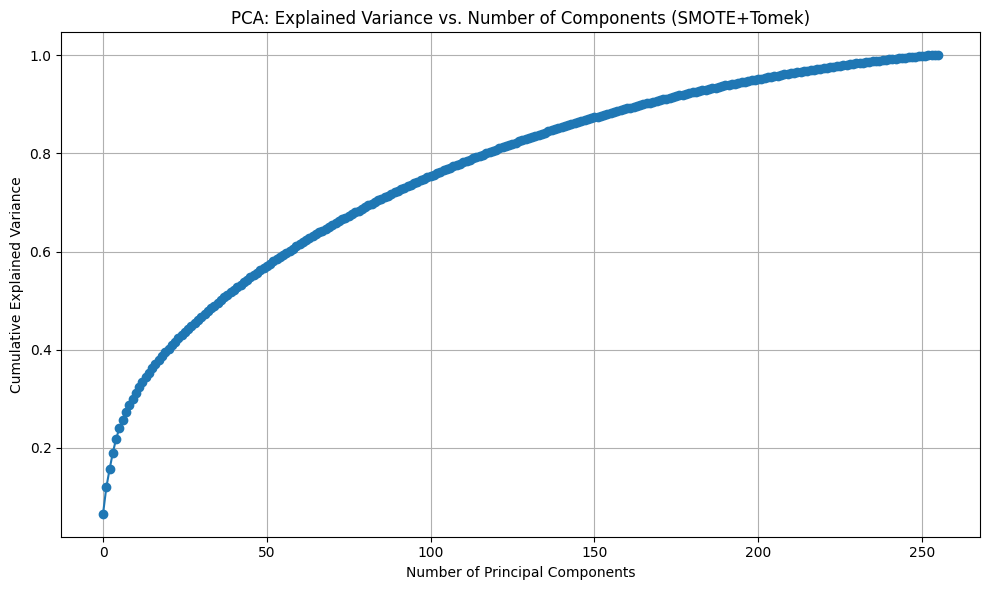

Number of PCs for 90% variance: 166
Number of PCs for 95% variance: 200
PCA (SMOTE+Tomek) features saved to: /kaggle/working/cnn_features_SMOTE_Tomek_PCA.csv


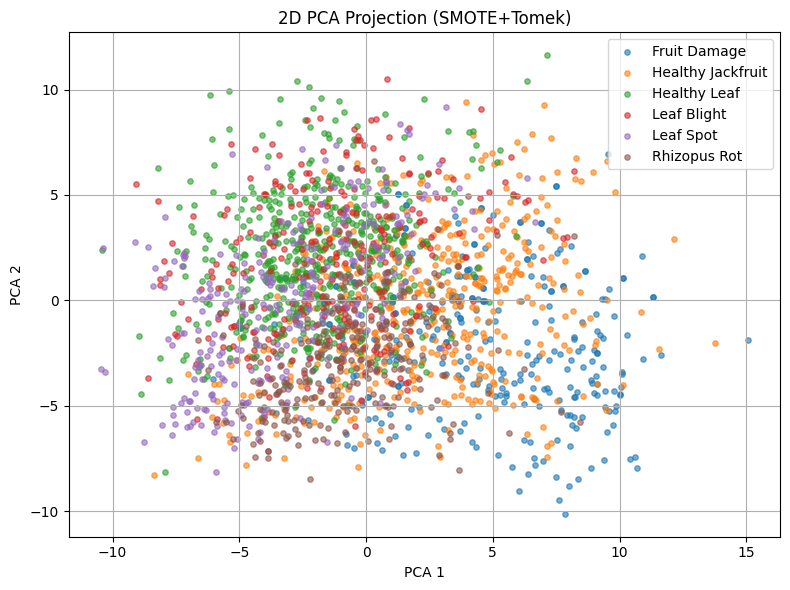

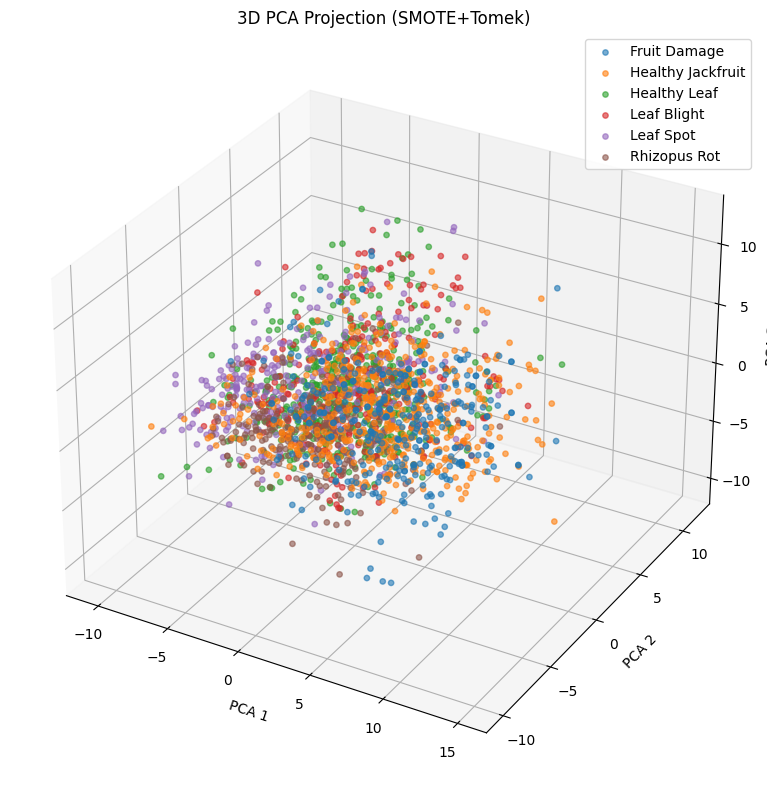

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load features
df = pd.read_csv('/kaggle/working/custom_cnn_features.csv')
print("Shape:", df.shape)
print("Columns:", df.columns[:10], "...")

# Columns to remove if present
drop_cols = {'label', 'class_idx', 'filename'}

# Keep only numeric columns (safer) then add label back
df_num = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
df_num = df_num.select_dtypes(include=[np.number])   # ensure purely numeric

# Optional: sanity check
assert df_num.shape[0] == df.shape[0], "Row count changed unexpectedly."
print("Numeric feature shape:", df_num.shape)

# Prepare X, y
X = df_num.values.astype(np.float32)
y = df['label'].values if 'label' in df.columns else np.array(['']*len(df))

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (fit on all components first)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components (SMOTE+Tomek)')
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/cnn_pca_explained_variance_SMOTE_Tomek.png')
plt.show()

# Choose components for 90% / 95%
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_90 = np.argmax(cum_var >= 0.90) + 1
n_95 = np.argmax(cum_var >= 0.95) + 1
print(f'Number of PCs for 90% variance: {n_90}')
print(f'Number of PCs for 95% variance: {n_95}')

# Save reduced (95%)
X_pca_final = X_pca[:, :n_95]
df_pca = pd.DataFrame(X_pca_final, columns=[f'pca_{i+1}' for i in range(n_95)])
df_pca['label'] = y
out_csv = '/kaggle/working/cnn_features_SMOTE_Tomek_PCA.csv'
df_pca.to_csv(out_csv, index=False)
print(f"PCA (SMOTE+Tomek) features saved to: {out_csv}")

# 2D PCA plot
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, s=15, alpha=0.6)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.title('2D PCA Projection (SMOTE+Tomek)')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig('/kaggle/working/cnn_pca_2d_plot_SMOTE_Tomek.png')
plt.show()

# 3D PCA plot
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(y):
    idx = (y == label)
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], label=label, s=15, alpha=0.6)
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
ax.set_title('3D PCA Projection (SMOTE+Tomek)')
ax.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/cnn_pca_3d_plot_SMOTE_Tomek.png')
plt.show()
